# **Predictive Maintenance for Manufacturing Machines**

## **Importing Libraries**

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## **Loading The Dataset**

In [9]:
maintenance = pd.read_csv (r"C:\Users\bbuser\Desktop\ai4i2020.csv")

In [10]:
maintenance.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [8]:
maintenance.shape

(10000, 14)

In [14]:
maintenance.columns.tolist()

['udi',
 'product_id',
 'type',
 'air_temperature_k',
 'process_temperature_k',
 'rotational_speed_rpm',
 'torque_nm',
 'tool_wear_min',
 'machine_failure',
 'twf',
 'hdf',
 'pwf',
 'osf',
 'rnf']

In [15]:
maintenance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    10000 non-null  int64  
 1   product_id             10000 non-null  object 
 2   type                   10000 non-null  object 
 3   air_temperature_k      10000 non-null  float64
 4   process_temperature_k  10000 non-null  float64
 5   rotational_speed_rpm   10000 non-null  int64  
 6   torque_nm              10000 non-null  float64
 7   tool_wear_min          10000 non-null  int64  
 8   machine_failure        10000 non-null  int64  
 9   twf                    10000 non-null  int64  
 10  hdf                    10000 non-null  int64  
 11  pwf                    10000 non-null  int64  
 12  osf                    10000 non-null  int64  
 13  rnf                    10000 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 1.1+ M

In [16]:
maintenance.describe()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,twf,hdf,pwf,osf,rnf
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## **Normalize column names**

In [17]:
maintenance.columns = [c.lower().strip().replace(" ", "_").replace("[","").replace("]","").replace("/","_").replace("-","_") for c in maintenance.columns]

## **Create binary and multiclass targets**

In [20]:
# binary target
if 'machine_failure' in maintenance.columns:
    maintenance['target_failure'] = maintenance['machine_failure'].astype(int)
else:
    raise KeyError("machine_failure column not found — check column names")

# multiclass label from flags (only label rows with exactly one flag to keep it single-label)
flags = ['twf','hdf','pwf','osf','rnf']
def failure_type_from_flags(row):
    present = [f for f in flags if f in maintenance.columns and int(row[f])==1]
    if len(present)==1:
        return present[0].upper()   # 'TWF','HDF', ...
    elif len(present)==0:
        return 'NONE'
    else:
        return 'MULTIPLE'
maintenance['failure_type'] = maintenance.apply(failure_type_from_flags, axis=1)
maintenance['failure_type'].value_counts()

failure_type
NONE        9652
HDF          106
PWF           80
OSF           78
TWF           42
MULTIPLE      24
RNF           18
Name: count, dtype: int64

## **Choose feature columns**

In [28]:
num_keywords = ['air_temperature','process_temperature','rotational_speed','torque','tool_wear']
num_features = [c for c in maintenance.columns if any(k in c for k in num_keywords)]
cat_features = ['type'] if 'type' in maintenance.columns else []
print("numeric:", num_features)
print("  ")
print("categorical:", cat_features)

numeric: ['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']
  
categorical: ['type']


## **Preprocessor & Train/test split**

In [31]:
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_features), ('cat', categorical_transformer, cat_features)])

X = maintenance[num_features + cat_features]
y_bin = maintenance['target_failure']
y_multi = maintenance['failure_type']

# Split stratified on binary target for Model 1 (keeps failure class proportion)
X_train, X_test, yb_train, yb_test, ym_train, ym_test = train_test_split(X, y_bin, y_multi, test_size=0.2, stratify=y_bin, random_state=42)

## **Model 1 (RandomForest, GradientBoosting, LogisticRegression)**

In [32]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

models_bin = {
  'RandomForest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
  'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
  'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', random_state=42)
}

trained_bin = {}
for name, clf in models_bin.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', clf)])
    pipe.fit(X_train, yb_train)
    trained_bin[name] = pipe
    # quick score at 0.5 threshold
    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
        probs = pipe.predict_proba(X_test)[:,1]
    else:
        probs = pipe.decision_function(X_test)  # fallback
    preds = (probs >= 0.5).astype(int)
    from sklearn.metrics import precision_score, recall_score
    print(name, "precision:", precision_score(yb_test, preds), "recall:", recall_score(yb_test, preds), "AP:", average_precision_score(yb_test, probs))

RandomForest precision: 0.9090909090909091 recall: 0.4411764705882353 AP: 0.7719662143762689
GradientBoosting precision: 0.8448275862068966 recall: 0.7205882352941176 AP: 0.8095285655635058
LogisticRegression precision: 0.1414141414141414 recall: 0.8235294117647058 AP: 0.38179015732339133


## **Evaluate Model 1 — Precision-Recall curve & threshold tuning**

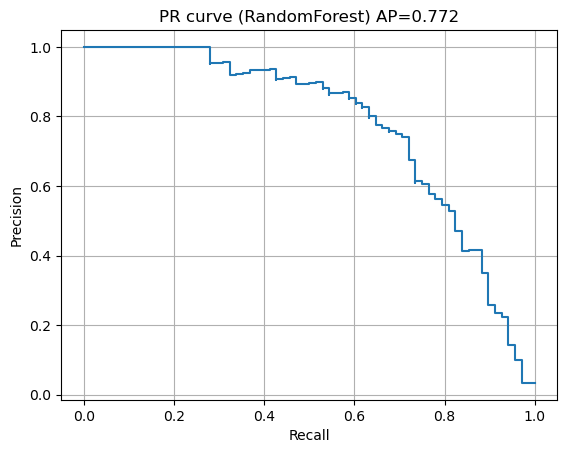

threshold for recall >= 0.85: 0.100 (precision 0.417, recall 0.882)


In [33]:
# Example: plot PR curve for RandomForest
rf = trained_bin['RandomForest']
probs = rf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(yb_test, probs)
ap = average_precision_score(yb_test, probs)
plt.step(recall, precision, where='post')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR curve (RandomForest) AP={ap:.3f}')
plt.grid(True); plt.show()

# Choose a threshold to favor recall (e.g., recall >= 0.85)
target_recall = 0.85
# thresholds length = len(precision)-1; align carefully
best = None
for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
    if r >= target_recall:
        if best is None or p > best[0]:
            best = (p, r, t)
if best:
    print("threshold for recall >= {:.2f}: {:.3f} (precision {:.3f}, recall {:.3f})".format(target_recall, best[2], best[0], best[1]))
else:
    print("no threshold yields that recall; consider using a different model or resampling")

## **Model 2 (only rows with single, real failure)**

=== DecisionTree ===
              precision    recall  f1-score   support

         HDF      0.800     0.952     0.870        21
         OSF      1.000     0.750     0.857        16
         PWF      0.941     1.000     0.970        16
         RNF      0.400     0.500     0.444         4
         TWF      1.000     0.750     0.857         8

    accuracy                          0.862        65
   macro avg      0.828     0.790     0.800        65
weighted avg      0.884     0.862     0.863        65



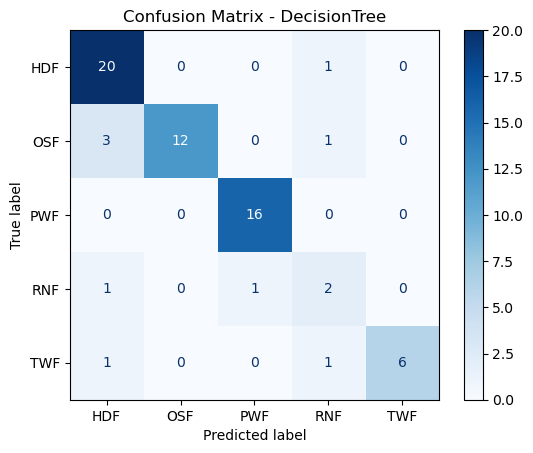

=== SVM ===
              precision    recall  f1-score   support

         HDF      0.778     1.000     0.875        21
         OSF      0.875     0.875     0.875        16
         PWF      0.933     0.875     0.903        16
         RNF      0.000     0.000     0.000         4
         TWF      1.000     0.875     0.933         8

    accuracy                          0.862        65
   macro avg      0.717     0.725     0.717        65
weighted avg      0.819     0.862     0.835        65



C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


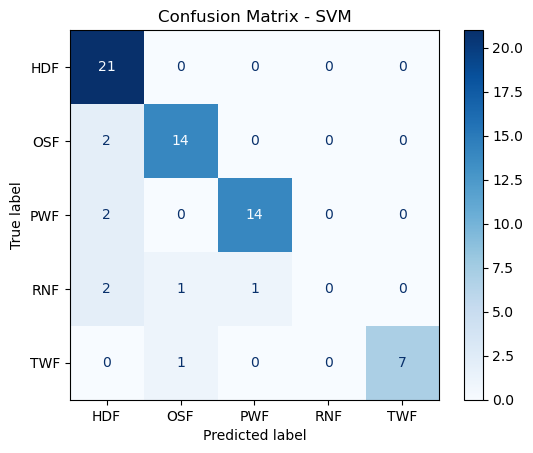

=== GaussianNB ===
              precision    recall  f1-score   support

         HDF      0.741     0.952     0.833        21
         OSF      0.867     0.812     0.839        16
         PWF      0.846     0.688     0.759        16
         RNF      0.333     0.250     0.286         4
         TWF      1.000     0.875     0.933         8

    accuracy                          0.800        65
   macro avg      0.757     0.715     0.730        65
weighted avg      0.805     0.800     0.795        65



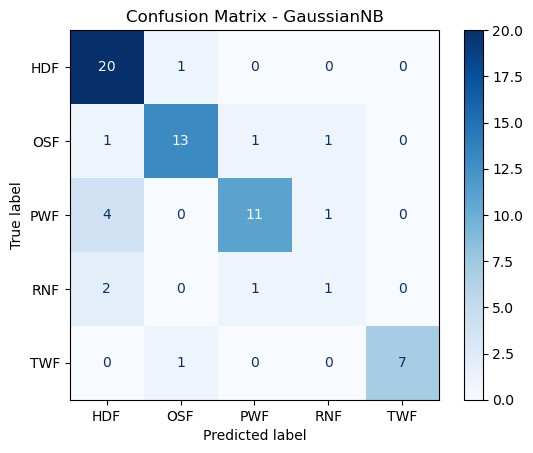

C:\Users\bbuser\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:32:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
              precision    recall  f1-score   support

         HDF      0.875     1.000     0.933        21
         OSF      1.000     0.750     0.857        16
         PWF      0.800     1.000     0.889        16
         RNF      0.000     0.000     0.000         4
         TWF      0.889     1.000     0.941         8

    accuracy                          0.877        65
   macro avg      0.713     0.750     0.724        65
weighted avg      0.835     0.877     0.847        65



C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


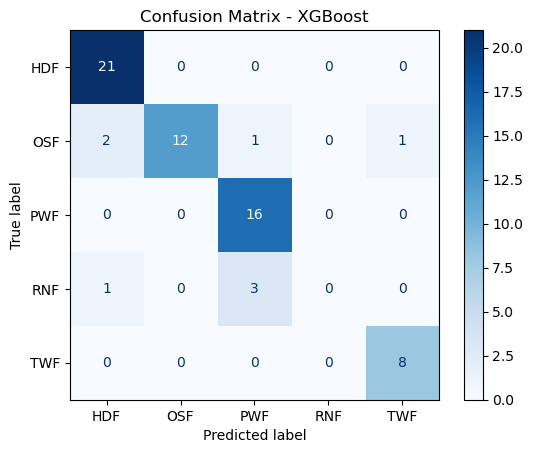

In [41]:
# keep only rows where failure_type is one single label among the 5 flags
major_types = ['TWF','HDF','PWF','OSF','RNF']
mask = maintenance['failure_type'].isin(major_types)
df_mc = maintenance[mask].copy()
X_mc = df_mc[num_features + cat_features]
y_mc = df_mc['failure_type']

# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_mc_encoded = le.fit_transform(y_mc)   # maps 'TWF','HDF',... → integers

# Train/test split using encoded labels
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(
    X_mc, y_mc_encoded, test_size=0.2, stratify=y_mc_encoded, random_state=42
)

# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models_multi = {
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'GaussianNB': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

for name, clf in models_multi.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', clf)])
    pipe.fit(Xtr, ytr)
    preds = pipe.predict(Xte)

    print(f"=== {name} ===")
    # report with original string labels
    print(classification_report(yte, preds, target_names=le.classes_, digits=3))

    cm = confusion_matrix(yte, preds)  # yte and preds are integers
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
